<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/notebooks/exotic.Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet50, One Cycle LR

In [1]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [2]:
try:
    import google.colab
    IN_COLAB = True
    ! pip install torchvision
    ! pip install torchinfo


    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

    !rm -rf trained
    !cp -r /content/drive/MyDrive/AML/trained/ ./trained
except:
    IN_COLAB = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


## Show device available

In [3]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Show model arquitecture

In [ ]:
from torchinfo import summary
import modular.models as models
from prettytable import PrettyTable

In [ ]:
amlresnet50 = models.AMLResnet50(out_dim=10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
batch_size = 16
img_size = 232
summary(model=amlresnet50, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
AMLResnet50 (AMLResnet50)                     [32, 3, 232, 232]    [32, 10]             --                   Partial
├─ResNet (net)                                [32, 3, 232, 232]    [32, 2048]           --                   False
│    └─Conv2d (conv1)                         [32, 3, 232, 232]    [32, 64, 116, 116]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 116, 116]   [32, 64, 116, 116]   (128)                False
│    └─ReLU (relu)                            [32, 64, 116, 116]   [32, 64, 116, 116]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 116, 116]   [32, 64, 58, 58]     --                   --
│    └─Sequential (layer1)                    [32, 64, 58, 58]     [32, 256, 58, 58]    --                   False
│    │    └─Bottleneck (0)                    [32, 64, 58, 58]     [32, 256, 58,

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
_ = count_parameters(amlresnet50)

+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.0.weight |    2048    |
|  fc.0.bias  |    2048    |
| fc.2.weight |  1048576   |
|  fc.2.bias  |    512     |
| fc.4.weight |    512     |
|  fc.4.bias  |    512     |
| fc.6.weight |    5120    |
|  fc.6.bias  |     10     |
+-------------+------------+
Total Trainable Params: 1059338


## Fine tunning

In [1]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
amlresnet50 = models.AMLResnet50(out_dim=10)
# Let base train
amlresnet50.unfreeze_base()

train_transforms, validate_transforms = amlresnet50.transforms, amlresnet50.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.AdamW(params=amlresnet50.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 3

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('finetune.exotic.amlresnet50.pth')

# Mini batch
batch_size=150

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [2]:
results = train(model=amlresnet50,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.0791 | train_acc: 0.6261 | test_loss: 0.6346 | test_acc: 0.7814


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.7144 | train_acc: 0.7544 | test_loss: 0.4937 | test_acc: 0.8324


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.6167 | train_acc: 0.7886 | test_loss: 0.4846 | test_acc: 0.8285


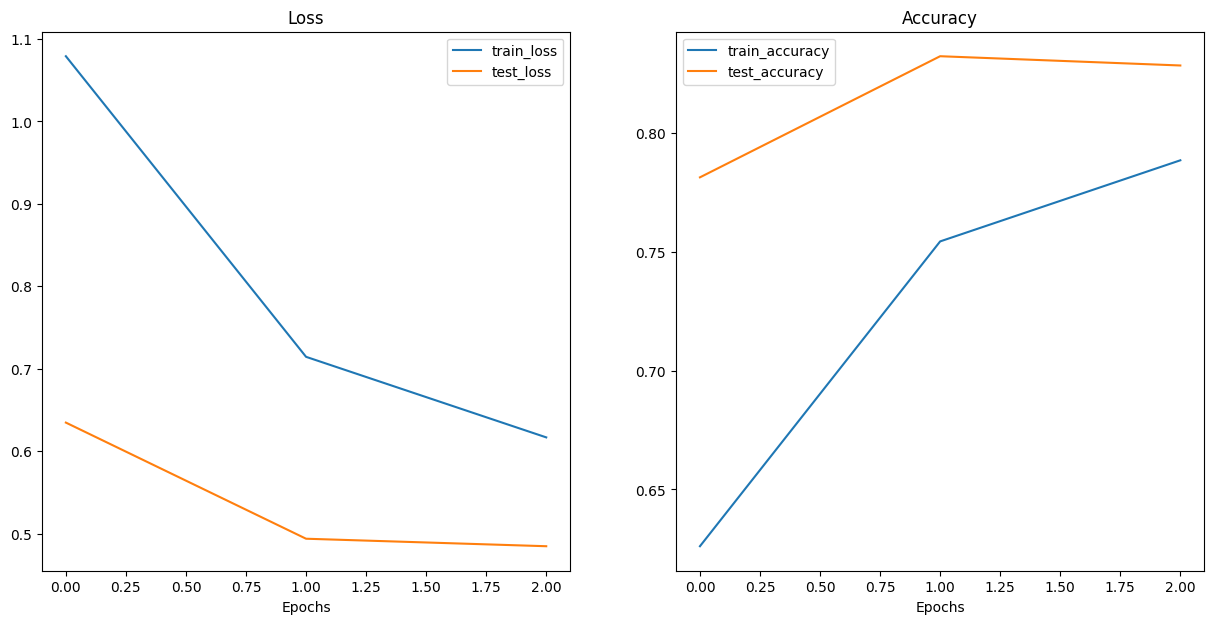

In [4]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [47]:
if IN_COLAB:
  from google.colab import files
  files.download('finetune.exotic.amlresnet50.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## OneCycleLR - cos

Sets the learning rate of each parameter group according to the 1cycle learning rate policy. The 1cycle policy anneals the learning rate from an initial learning rate to some maximum learning rate and then from that maximum learning rate to some minimum learning rate much lower than the initial learning rate. This policy was initially described in the paper Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates.

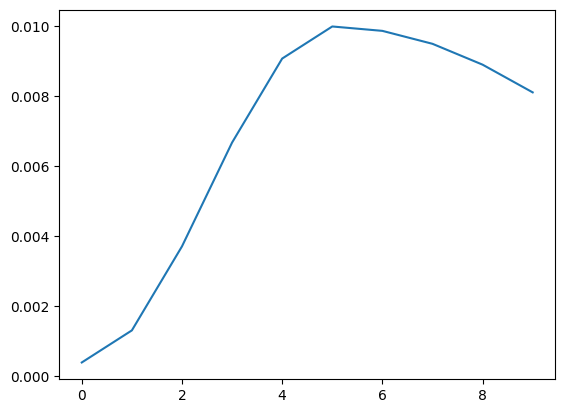

In [8]:
import torch
import matplotlib.pyplot as plt

model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=2, epochs=10)
lrs = []


for i in range(10):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.plot(lrs)

## Training find tunning AMLResnet50

In [ ]:
try:
    import google.colab
    IN_COLAB = True
    ! pip install torchvision
    ! pip install torchinfo
except:
    IN_COLAB = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from pathlib import Path

saved_data = torch.load(Path('trained/finetune.amlresnet50.pth'))
saved_data.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch', 'optimizer', 'model'])

In [ ]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Mode
amlresnet50 = models.AMLResnet50(out_dim=10)
# Recover state dict
state_dict = saved_data['model']
# Load saved state dict into the model
amlresnet50.load_state_dict(state_dict)
# Freeze base
amlresnet50.freeze_base()

train_transforms, validate_transforms = amlresnet50.transforms, amlresnet50.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.Adam(params=amlresnet50.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 25

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('amlresnet50.pth')

# Mini batch
batch_size=750

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [ ]:
results = train(model=amlresnet50,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 0.4900 | train_acc: 0.8325 | test_loss: 0.3878 | test_acc: 0.8672


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.4319 | train_acc: 0.8522 | test_loss: 0.3876 | test_acc: 0.8652


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.3474 | train_acc: 0.8798 | test_loss: 0.3979 | test_acc: 0.8673


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.4771 | train_acc: 0.8373 | test_loss: 0.3694 | test_acc: 0.8705


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.4670 | train_acc: 0.8388 | test_loss: 0.3674 | test_acc: 0.8720


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.4634 | train_acc: 0.8383 | test_loss: 0.3658 | test_acc: 0.8719


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.4642 | train_acc: 0.8396 | test_loss: 0.3631 | test_acc: 0.8748


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.4584 | train_acc: 0.8411 | test_loss: 0.3636 | test_acc: 0.8722


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.4584 | train_acc: 0.8410 | test_loss: 0.3593 | test_acc: 0.8754


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.4577 | train_acc: 0.8438 | test_loss: 0.3582 | test_acc: 0.8751


In [ ]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [ ]:
if IN_COLAB:
  from google.colab import files
  files.download('amlresnet50.pth')